# Tutorial: Accessing data from the Euclid ERO volume

<img style="position: absolute; right: 60px; top: 40px; height: 160px; width: 160px" src="https://datalabs.esa.int/datalab-icon/c11e47af-7ce9-4281-b3b5-475a180a256f" /> 

<div style="width: 70%;">

Copyright (c) European Space Agency, 2025.

This file is subject to the terms and conditions defined in file LICENSE.txt, which is part of this source code package. No part of the package, including this file, may be copied, modified, propagated, or distributed except according to the terms contained in the file LICENSE.txt.

</div>

**Last modified:** 14.03.2025

**Notebook summary**

The notebook demonstrates how to use the Euclid ERO volume on datalabs. The notebook will cover topics like how to load both images and catalogues from the volume then filter the catalogue for sources and make cutouts from the image for the filtered sources.

**Useful links:**

* [ERO data release information ](https://www.cosmos.esa.int/web/euclid/ero-public-release)
* [Astropy documentation for reading tables](https://docs.astropy.org/en/latest/io/ascii/read.html)

**Running the notebook:** This notebook has **read-only permissions**. You can still run and edit cells but if you would like to save your changes then you have to save the notebook to a different location - your workspace for example. The notebook is intended to be run using the **EUCLID-TOOLS kernel** that has all the necessary packages included.

***

In [1]:
from astropy import wcs
import astropy.units as u
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.nddata.utils import Cutout2D
import pandas as pd
import os
import glob

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from astropy.visualization import astropy_mpl_style, ImageNormalize, ZScaleInterval, PercentileInterval, AsinhStretch, SqrtStretch, SquaredStretch

First let's make a folder (if not already created) to save the output files from this notebook. All the example notebooks save their outputs to this same folder in your user workspace called: `'example_notebook_outputs/'`

In [2]:
#make a folder for the future cutouts
cutout_folder= '/media/user/example_notebook_outputs/cutouts/'
if not os.path.exists(cutout_folder):
    os.makedirs(cutout_folder)

## Loading the catalogue file

Small catalogue files (<1.6 GB) can be loaded using astropy. However the default process for reading ASCII tables with astropy read table is not memory efficient and may temporarily require much more memory than the size of the file (up to a factor of 5 to 10). Therefore it is recommended to use pandas instead. Pandas however struggles with reading sextractor format headers so the solution below combines the two packages. The header is extracted from the first 500 lines of the file with astropy. The column names extracted from the header are then handed over to pandas for reading the rest of the data.

In [3]:
ero_volume_path = '/data/euc_ero_data_01/'
file_path = ero_volume_path + 'ERO/Catalog/ERO-Abell2390-NISP-CAT/Euclid-NISP-J-ERO-Abell2390-Flattened.DR3.NISPdet.cat'

max_header_lenght = 500 
head_table = Table.read(file_path, format='ascii.sextractor', data_end = max_header_lenght)
t = Table.from_pandas(pd.read_table(file_path, comment='#', sep='\s+' , names = head_table.columns))

### Visualize the table as astropy table

In [4]:
#show table
print("Number of rows:", len(t))
print("Number of columns", len(t.columns))
# print(t2.columns) #printing all the columns
t

Number of rows: 310617
Number of columns 364


NUMBER,X_IMAGE,Y_IMAGE,ID_PARENT,EXT_NUMBER,FLUX_ISO,FLUXERR_ISO,MAG_ISO,MAGERR_ISO,FLUX_ISOCOR,FLUXERR_ISOCOR,MAG_ISOCOR,MAGERR_ISOCOR,FLUX_APER,FLUX_APER_1,FLUX_APER_2,FLUX_APER_3,FLUX_APER_4,FLUX_APER_5,FLUX_APER_6,FLUX_APER_7,FLUX_APER_8,FLUX_APER_9,FLUXERR_APER,FLUXERR_APER_1,FLUXERR_APER_2,FLUXERR_APER_3,FLUXERR_APER_4,FLUXERR_APER_5,FLUXERR_APER_6,FLUXERR_APER_7,FLUXERR_APER_8,FLUXERR_APER_9,MAG_APER,MAG_APER_1,MAG_APER_2,MAG_APER_3,MAG_APER_4,MAG_APER_5,MAG_APER_6,MAG_APER_7,MAG_APER_8,MAG_APER_9,MAGERR_APER,MAGERR_APER_1,MAGERR_APER_2,MAGERR_APER_3,MAGERR_APER_4,MAGERR_APER_5,MAGERR_APER_6,MAGERR_APER_7,MAGERR_APER_8,MAGERR_APER_9,FLUX_AUTO,FLUXERR_AUTO,MAG_AUTO,MAGERR_AUTO,KRON_RADIUS,FLUX_PETRO,FLUXERR_PETRO,MAG_PETRO,MAGERR_PETRO,PETRO_RADIUS,FLUX_GROWTH,FLUX_GROWTHSTEP,MAG_GROWTH,MAG_GROWTHSTEP,FLUX_RADIUS,BACKGROUND,MU_MAX,X_FOCAL,Y_FOCAL,X_WORLD,Y_WORLD,ALPHA_SKY,DELTA_SKY,ALPHA_J2000,DELTA_J2000,ALPHA_B1950,DELTA_B1950,ERRX2_IMAGE,ERRY2_IMAGE,ERRXY_IMAGE,ERRA_IMAGE,ERRB_IMAGE,ERRTHETA_IMAGE,ERRCXX_IMAGE,ERRCYY_IMAGE,ERRCXY_IMAGE,XPEAK_IMAGE,YPEAK_IMAGE,XPEAK_FOCAL,YPEAK_FOCAL,XPEAK_WORLD,YPEAK_WORLD,ALPHAPEAK_SKY,DELTAPEAK_SKY,ALPHAPEAK_J2000,DELTAPEAK_J2000,ALPHAPEAK_B1950,DELTAPEAK_B1950,XMIN_IMAGE,YMIN_IMAGE,XMAX_IMAGE,YMAX_IMAGE,XWIN_IMAGE,YWIN_IMAGE,ERRX2WIN_IMAGE,ERRY2WIN_IMAGE,ERRXYWIN_IMAGE,ERRAWIN_IMAGE,ERRBWIN_IMAGE,ERRTHETAWIN_IMAGE,ERRCXXWIN_IMAGE,ERRCYYWIN_IMAGE,ERRCXYWIN_IMAGE,X2_IMAGE,Y2_IMAGE,XY_IMAGE,A_IMAGE,B_IMAGE,THETA_IMAGE,ELONGATION,ELLIPTICITY,CXX_IMAGE,CYY_IMAGE,CXY_IMAGE,ISOAREAF_IMAGE,ISOAREA_IMAGE,X2WIN_IMAGE,Y2WIN_IMAGE,XYWIN_IMAGE,CXXWIN_IMAGE,CYYWIN_IMAGE,CXYWIN_IMAGE,AWIN_IMAGE,BWIN_IMAGE,THETAWIN_IMAGE,CLASS_STAR,FWHM_IMAGE,XPSF_IMAGE,YPSF_IMAGE,ALPHAPSF_J2000,DELTAPSF_J2000,FLUX_PSF,FLUXERR_PSF,MAG_PSF,MAGERR_PSF,FLUX_POINTSOURCE,FLUXERR_POINTSOURCE,MAG_POINTSOURCE,MAGERR_POINTSOURCE,FLUX_DISK,FLUXERR_DISK,MAG_DISK,MAGERR_DISK,MU_MAX_DISK,MU_EFF_DISK,MU_MEAN_DISK,FLUX_SPHEROID,FLUXERR_SPHEROID,MAG_SPHEROID,MAGERR_SPHEROID,MU_MAX_SPHEROID,MU_EFF_SPHEROID,MU_MEAN_SPHEROID,DISK_INCLINATION,DISK_INCLINATIONERR,DISK_THETA_IMAGE,DISK_THETAERR_IMAGE,SPHEROID_SERSICN,SPHEROID_SERSICNERR,SPHEROID_THETA_IMAGE,SPHEROID_THETAERR_IMAG,SPHEROID_REFF_IMAGE,SPHEROID_REFFERR_IMAGE,FLUX_MODEL,FLUXERR_MODEL,MAG_MODEL,MAGERR_MODEL,MU_MAX_MODEL,FLUX_MAX_MODEL,FLUX_EFF_MODEL,FLUX_MEAN_MODEL,MU_EFF_MODEL,MU_MEAN_MODEL,XMODEL_IMAGE,YMODEL_IMAGE,CXXMODEL_IMAGE,CYYMODEL_IMAGE,CXYMODEL_IMAGE,SPREAD_MODEL,SPREADERR_MODEL,NOISEAREA_MODEL,NITER_MODEL,VECTOR_MODEL,VECTOR_MODEL_1,VECTOR_MODEL_2,VECTOR_MODEL_3,VECTOR_MODEL_4,VECTOR_MODEL_5,VECTOR_MODEL_6,VECTOR_MODEL_7,VECTOR_MODEL_8,VECTOR_MODEL_9,VECTOR_MODEL_10,VECTOR_MODEL_11,VECTOR_MODELERR,VECTOR_MODELERR_1,VECTOR_MODELERR_2,VECTOR_MODELERR_3,VECTOR_MODELERR_4,VECTOR_MODELERR_5,VECTOR_MODELERR_6,VECTOR_MODELERR_7,VECTOR_MODELERR_8,VECTOR_MODELERR_9,VECTOR_MODELERR_10,VECTOR_MODELERR_11,MATRIX_MODELERR,MATRIX_MODELERR_1,MATRIX_MODELERR_2,MATRIX_MODELERR_3,MATRIX_MODELERR_4,MATRIX_MODELERR_5,MATRIX_MODELERR_6,MATRIX_MODELERR_7,MATRIX_MODELERR_8,MATRIX_MODELERR_9,MATRIX_MODELERR_10,MATRIX_MODELERR_11,MATRIX_MODELERR_12,MATRIX_MODELERR_13,MATRIX_MODELERR_14,MATRIX_MODELERR_15,MATRIX_MODELERR_16,MATRIX_MODELERR_17,MATRIX_MODELERR_18,MATRIX_MODELERR_19,MATRIX_MODELERR_20,MATRIX_MODELERR_21,MATRIX_MODELERR_22,MATRIX_MODELERR_23,MATRIX_MODELERR_24,MATRIX_MODELERR_25,MATRIX_MODELERR_26,MATRIX_MODELERR_27,MATRIX_MODELERR_28,MATRIX_MODELERR_29,MATRIX_MODELERR_30,MATRIX_MODELERR_31,MATRIX_MODELERR_32,MATRIX_MODELERR_33,MATRIX_MODELERR_34,MATRIX_MODELERR_35,MATRIX_MODELERR_36,MATRIX_MODELERR_37,MATRIX_MODELERR_38,MATRIX_MODELERR_39,MATRIX_MODELERR_40,MATRIX_MODELERR_41,MATRIX_MODELERR_42,MATRIX_MODELERR_43,MATRIX_MODELERR_44,MATRIX_MODELERR_45,MATRIX_MODELERR_46,MATRIX_MODELERR_47,MATRIX_MODELERR_48,MATRIX_MODELERR_49,MATRIX_MODELERR_50,MATRIX_MODELERR_51,MATRIX_MODELERR_52,MATRIX_MODELERR_53,MATRIX_MODELERR_54,MATRIX_MODELERR_55,MATRIX_MODELERR_56,MATRIX_MODELERR_57

## Filtering the catalogue for some galaxies

The columns in the catalogue file/table are output from a program called sextractor. Below is a simple (imperfect) filtering of the catalogue for getting some galaxies. We are using the class_star parameter that describes the probability that a source is a star (1 for star, 0 for not). In this example we are looking for galaxies so we want this value to be small. 

You are welcome to change this filtering and make it more complex to suit your needs. There are 364 columns to use and here in the [sextractor documentation](https://sextractor.readthedocs.io/en/latest/Measurements.html) you can find some descriptions about what they mean.

In [5]:
filtered = t[(t['FLUX_ISO'] > 100000) & (t['CLASS_STAR'] < 0.1)]
filtered['NUMBER', 'X_IMAGE','Y_IMAGE', 'ALPHA_SKY', 'DELTA_SKY','CLASS_STAR', 'FLUX_ISO', 'FLUXERR_ISO', 'FLUX_RADIUS', 'ELLIPTICITY']

NUMBER,X_IMAGE,Y_IMAGE,ALPHA_SKY,DELTA_SKY,CLASS_STAR,FLUX_ISO,FLUXERR_ISO,FLUX_RADIUS,ELLIPTICITY
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64
8093,6366.6699,951.479,328.4525985,17.2056914,0.029,134507.0,352.3109,3.419,0.278
11132,9223.1514,1211.2266,328.2033939,17.2272501,0.029,137374.8,181.5242,4.109,0.068
11223,6149.2329,1124.3782,328.4715723,17.2200925,0.029,266252.9,1732051000000000.0,4.794,0.183
11945,6983.9263,1298.6451,328.398753,17.2346273,0.029,103828.8,185.7747,2.625,0.644
13118,5541.0112,1375.8959,328.5246488,17.2410244,0.029,123684.6,340.3564,2.915,0.345
15790,9641.8203,1502.238,328.1668368,17.251461,0.029,204582.7,251.6926,3.494,0.316
16258,5729.8335,1539.8779,328.5081823,17.2546983,0.03,140871.9,3605609000000000.0,3.639,0.09
16278,6339.9185,1571.9481,328.4549487,17.2573929,0.029,199837.9,263.0036,4.351,0.077
19149,5103.2979,1630.3882,328.562859,17.262203,0.029,184633.1,1414214000000000.0,4.883,0.248


## Making cutouts for filtered sources

**Loading full image**

In [6]:
#loading full iamge
fits_file_path = ero_volume_path + 'ERO/Stack/ERO-Abell2390/Euclid-NISP-J-ERO-Abell2390-LSB.DR3.fits.gz'
full_image_data, header = fits.getdata(fits_file_path, header=True)
print("The size of original image: ", full_image_data.shape)

The size of original image:  (14000, 14000)


**Making one cutout**

Making a cutout for one of the sources in our filtered table - source on line 13, idx 12 (just because it looks nice)

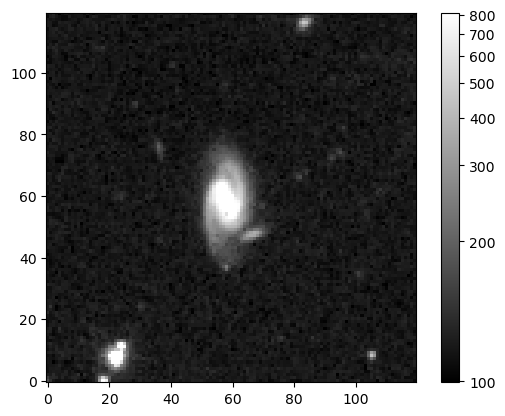

In [7]:
id = 12
cutout = Cutout2D(data=full_image_data, position = (filtered[id]['X_IMAGE'], filtered[id]['Y_IMAGE']), size= 0.6 * u.arcmin, wcs=wcs.WCS(header))

plt.figure()
plt.imshow(cutout.data, cmap='gray', origin='lower', norm=ImageNormalize(cutout.data, interval=PercentileInterval(99.), stretch=AsinhStretch()))
plt.colorbar();

**Making more cutouts**

Here is a function for looping over a table and making cutouts for all sources.

In [8]:
def makeCutouts(img_data, source_table):
    for i, source in enumerate(source_table):
        print('Making cutout number:', str(i) + '/' + str(len(source_table)))
        cutout = Cutout2D(data=img_data, position = (source['X_IMAGE'], source['Y_IMAGE']), size= 0.5 * u.arcmin, wcs=wcs.WCS(header))

        hdu = fits.PrimaryHDU(cutout.data)
        hdu.writeto(cutout_folder + 'ero_cat_cut{0}.fits'.format(str(i).zfill(2)), overwrite=True)

In [9]:
makeCutouts(full_image_data, filtered[25:35])

Making cutout number: 0/10
Making cutout number: 1/10
Making cutout number: 2/10
Making cutout number: 3/10
Making cutout number: 4/10
Making cutout number: 5/10
Making cutout number: 6/10
Making cutout number: 7/10
Making cutout number: 8/10
Making cutout number: 9/10


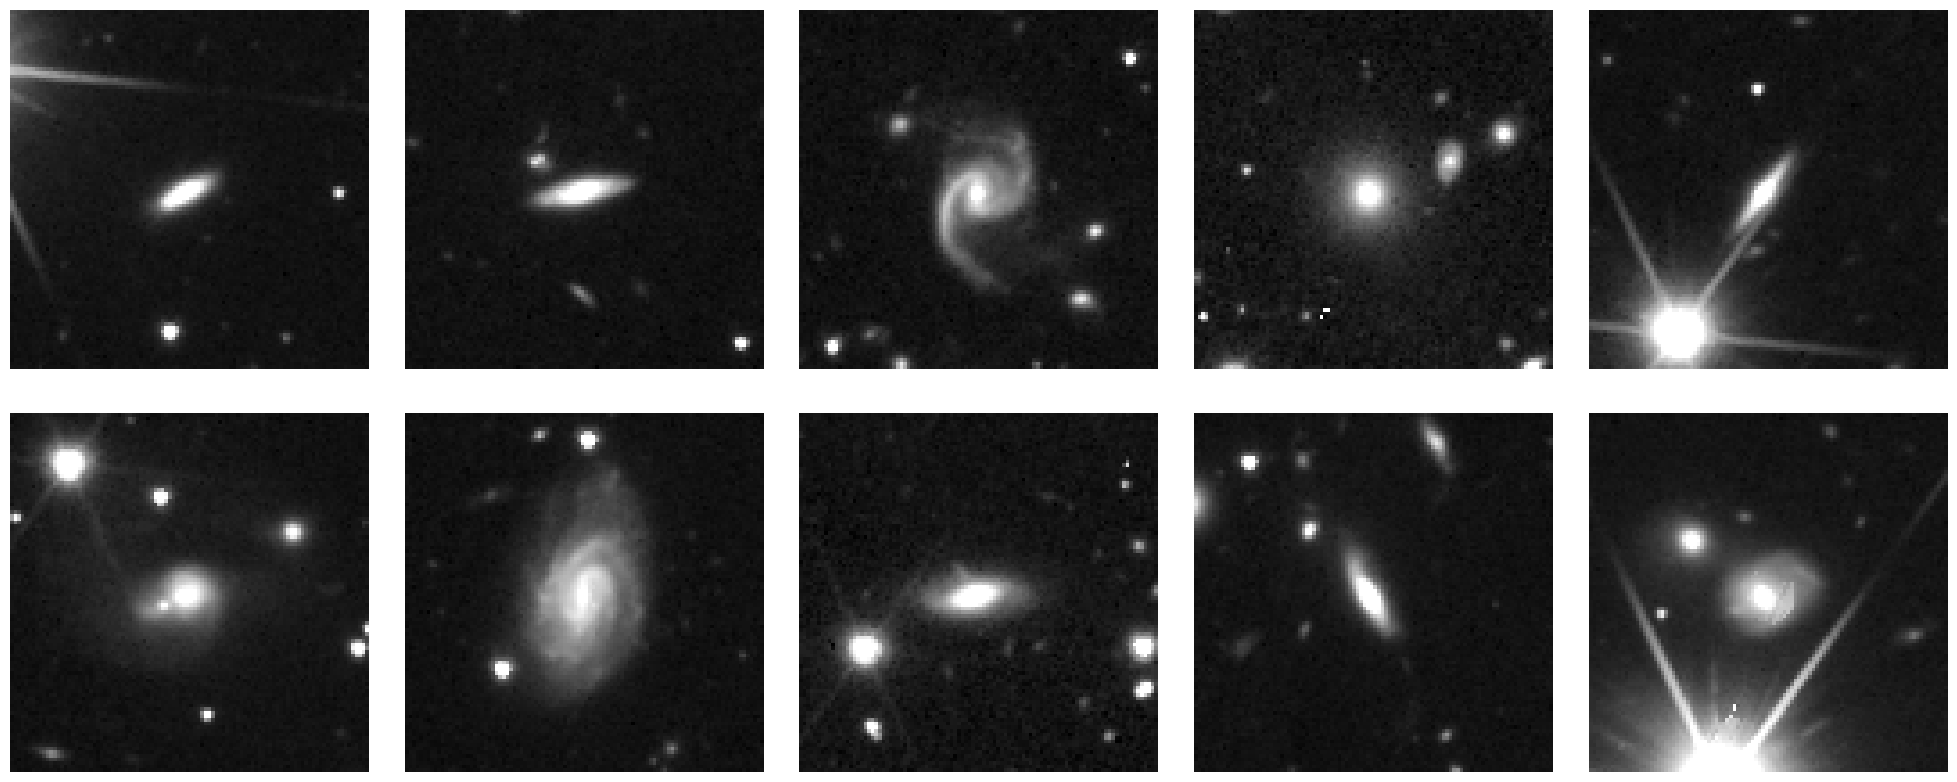

In [10]:
#showing 10 of the cutouts
files = glob.glob(cutout_folder + 'ero_cat_cut*.fits')

_, axes = plt.subplots(2, 5, figsize=(25, 10))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for ax, img_path in zip(axes.flatten(), files):
    cut_img_data = fits.getdata(img_path, ext=0)
    ax.imshow(cut_img_data, cmap='gray', origin='lower', norm=ImageNormalize(cutout.data, interval=PercentileInterval(99.3), stretch=AsinhStretch()))
    ax.axis("off")

***